In [1]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt  
import seaborn as sns

import datetime as dt

In [2]:
df = pd.read_excel("Retail_init_cleaned.xlsx")

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [4]:
df_date = df.set_index('InvoiceDate')

In [5]:
df_date['Quantity'].resample('M').sum()

InvoiceDate
2010-12-31    312280
2011-01-31    349147
2011-02-28    265638
2011-03-31    348544
2011-04-30    292225
2011-05-31    373685
2011-06-30    363699
2011-07-31    369432
2011-08-31    398938
2011-09-30    544899
2011-10-31    593908
2011-11-30    681888
2011-12-31    287413
Freq: M, Name: Quantity, dtype: int64

In [6]:
df_date['Quantity'].resample('M').nunique()

InvoiceDate
2010-12-31    105
2011-01-31     93
2011-02-28     90
2011-03-31    101
2011-04-30     98
2011-05-31    106
2011-06-30    114
2011-07-31    103
2011-08-31    118
2011-09-30    133
2011-10-31    134
2011-11-30    141
2011-12-31    100
Freq: M, Name: Quantity, dtype: int64

In [7]:
#12-month period --> remove the Dec 2011 data 
df = df[df['InvoiceDate'].dt.date < dt.date(2011,12,1)]

In [8]:
# divide customers into monthly cohort according to the date they made the first purchase

cohort = df.groupby('CustomerID')['InvoiceDate'].min().dt.to_period('m')

In [9]:
cohort = cohort.to_frame()

In [10]:
cohort.columns = ['Cohort']

In [11]:
cohort

,Cohort
CustomerID,
12346,2011-01
12347,2010-12
12348,2010-12
12349,2011-11
12350,2011-02
...,...
18280,2011-03
18281,2011-06
18282,2011-08


In [12]:
df_cohort = df.set_index('CustomerID').join(cohort)

In [13]:
df_cohort.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,Amount,Cohort
CustomerID,,,,,,,,,
12346,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,United Kingdom,77183.6,2011-01
12347,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,2010-12-07 14:57:00,2.10,Iceland,25.2,2010-12
12347,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2010-12-07 14:57:00,4.25,Iceland,17.0,2010-12
12347,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,2010-12-07 14:57:00,3.25,Iceland,39.0,2010-12
12347,537626,22492,MINI PAINT SET VINTAGE,36,2010-12-07 14:57:00,0.65,Iceland,23.4,2010-12


In [14]:
df_cohort['SalesPeriod'] = df_cohort['InvoiceDate'].dt.to_period('m')

In [15]:
df_cohort.reset_index(inplace = True)

In [16]:
df_cohort.groupby(['Cohort', 'SalesPeriod']).CustomerID.nunique()

Cohort   SalesPeriod
2010-12  2010-12        885
         2011-01        324
         2011-02        286
         2011-03        340
         2011-04        321
                       ... 
2011-09  2011-10         70
         2011-11         90
2011-10  2011-10        358
         2011-11         86
2011-11  2011-11        324
Name: CustomerID, Length: 78, dtype: int64

In [17]:
retention = df_cohort.groupby(['Cohort', 'SalesPeriod']).CustomerID.nunique().reset_index()

#create pivot table
retention = retention.pivot(index = 'SalesPeriod', columns = 'Cohort', values = 'CustomerID')

In [18]:
def reten_rate(df):
    for x in range(len(df)):
        df.iloc[:, x] = df.iloc[:, x].divide(df.iloc[x, x])
    return df

In [19]:
reten_rate(retention)

Cohort,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11
SalesPeriod,,,,,,,,,,,,
2010-12,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01,0.366102,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02,0.323164,0.220624,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-03,0.384181,0.266187,0.186842,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-04,0.362712,0.230216,0.186842,0.150442,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-05,0.397740,0.321343,0.284211,0.252212,0.213333,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
2011-06,0.362712,0.287770,0.271053,0.199115,0.203333,0.190141,1.000000,NaN,NaN,NaN,NaN,NaN
2011-07,0.349153,0.247002,0.247368,0.223451,0.210000,0.172535,0.173554,1.000000,NaN,NaN,NaN,NaN
2011-08,0.353672,0.242206,0.252632,0.168142,0.196667,0.172535,0.157025,0.180851,1.000000,NaN,NaN,NaN


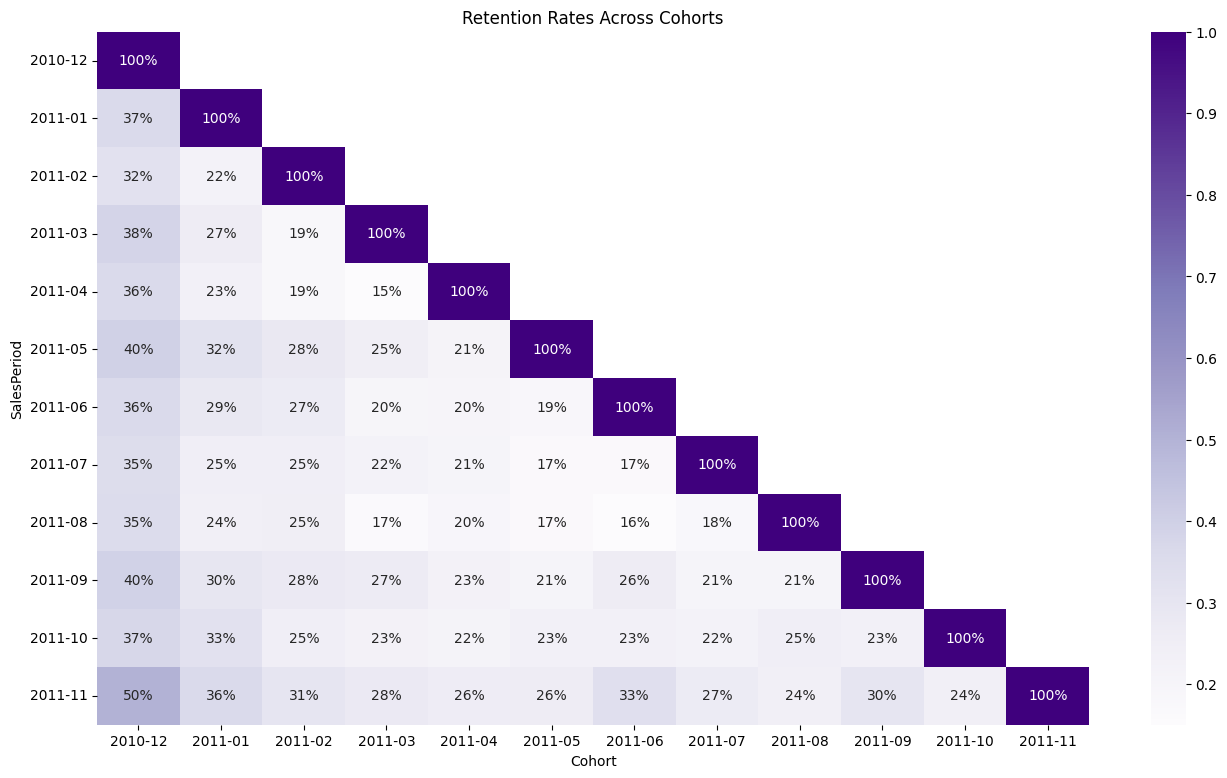

In [20]:
plt.figure(figsize = (16,9))

plt.title('Retention Rates Across Cohorts')

sns.heatmap(data = retention, annot = True, fmt = '.0%', cmap = "Purples")

plt.show()